In [273]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [274]:
!pip install torch==1.5.1

In [275]:
!pip install transformers

In [276]:
% pip install sentencepiece

In [277]:
import os
import math

import torch
from torch.nn import CrossEntropyLoss
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
import pandas as pd
from pylab import rcParams
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [278]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


In [279]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [280]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Engine_design/Data_Aug/trainset1.csv')
df1.head()

,body,intent_2
0,Hi piston! My crankshaft depends on your bore ...,Dependencies between design parameters
1,Hi flywheel! My crankshaft depends on your fly...,Dependencies between design parameters
2,min of 40,Selected design parameter values for objective(s)
3,My flywheel also depends on your crankshaft be...,Dependencies between design parameters
4,45 seems decent,Selected design parameter values for objective(s)


In [281]:
df1 = shuffle(df1)
len(df1)

518

In [282]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Engine_design/Data_Aug/Validation_data.csv')
df2 = shuffle(df2)
len(df2)

48

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency of categories')

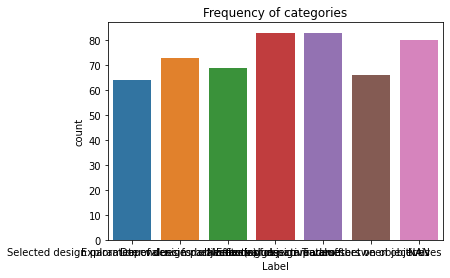

In [283]:
sns.countplot(df1['intent_2'])
plt.xlabel('Label')
plt.title('Frequency of categories')

In [284]:
df1['Body'] = df1['body'].astype('str')

In [285]:
df2 
df2['Body'] = df2['body'].astype('str')
df2['Intent'] = df2['intent_2'].astype("category")
print(df2['Intent'].unique)
df2.drop(labels=["intent_2","body"], axis=1,inplace=True)
df2['Intent'] = df2['Intent'].cat.codes

<bound method Series.unique of 29                          Monitoring objective values
8            Effects of design parameters on objectives
4                Dependencies between design parameters
15               Exploration of design parameter values
23                          Monitoring objective values
40                          Tradeoff between objectives
3                Dependencies between design parameters
16               Exploration of design parameter values
36                                                  NAN
0                Dependencies between design parameters
17               Exploration of design parameter values
42                          Tradeoff between objectives
27                          Monitoring objective values
1                Dependencies between design parameters
24                          Monitoring objective values
10           Effects of design parameters on objectives
44    Selected design parameter values for objective(s)
47    Selected de

In [286]:
df1['Intent'] = df1['intent_2'].astype("category")

In [287]:
df1.drop(labels=["intent_2","body"], axis=1,inplace=True)

In [288]:
df1['Intent']

86     Selected design parameter values for objective(s)
478               Exploration of design parameter values
502               Dependencies between design parameters
457    Selected design parameter values for objective(s)
251                          Monitoring objective values
                             ...                        
407           Effects of design parameters on objectives
63                Dependencies between design parameters
474    Selected design parameter values for objective(s)
264                                                  NAN
204                          Monitoring objective values
Name: Intent, Length: 518, dtype: category
Categories (7, object): ['Dependencies between design parameters', 'Effects of design parameters on objectives',
                         'Exploration of design parameter values', 'Monitoring objective values', 'NAN',
                         'Selected design parameter values for objectiv..., 'Tradeoff between objectives']

In [289]:
df1['Intent'] = df1['Intent'].cat.codes

In [290]:
#df1.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/Engine_design/check.csv', index=False)

In [291]:
#df1['Intent'].unique

In [292]:
#df2['Intent'].value_counts()

In [293]:
class_names = ['Dependencies between design parameters', 'Effects of design parameters on objectives',
                         'Exploration of design parameter values', 'Monitoring objective values', 'NAN',
                         'Selected design parameter values for objectives', 'Tradeoff between objectives']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


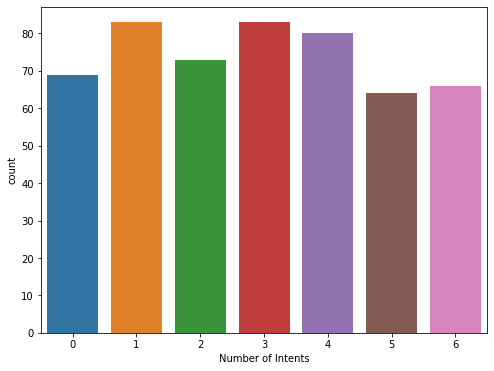

In [294]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df1.Intent)
plt.xlabel('Number of Intents');

In [295]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [296]:
input_txt = "whats the factor of safety"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=20, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [297]:
MAX_LEN=512
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")

In [298]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [299]:
token_lens = []

for txt in df1['Body']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


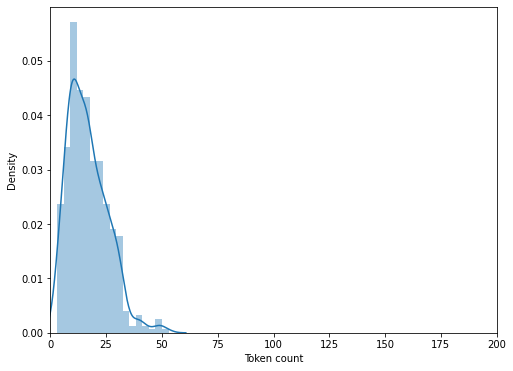

In [300]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [301]:
class QaDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }


In [302]:
df_train = df1
df_val = df2

In [303]:
df_train.shape, df_val.shape

((518, 2), (48, 2))

In [304]:
#df_train = df_train.iloc[0:2748,]

In [305]:
#df_val = df_val.iloc[0:1372,]

In [306]:
#df_test = df_test.iloc[0:1372,]

In [307]:
#df_train.shape, df_val.shape

In [308]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = QaDataset(
    reviews=df.Body.to_numpy(),
    targets=df.Intent.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [309]:
BATCH_SIZE = 2

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [310]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 7)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [311]:
EPOCHS = 3

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [312]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [313]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(2,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [314]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(2,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)


In [315]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/QA/models/xlnet_modelnd.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 1.857129818684346 Train accuracy 0.23552123552123552
Val loss 1.461107812821865 Val accuracy 0.4791666666666667

Epoch 2/3
----------
Train loss 1.1754737567717504 Train accuracy 0.5733590733590733
Val loss 1.4989269599318504 Val accuracy 0.5208333333333334

Epoch 3/3
----------
Train loss 0.5522305235899553 Train accuracy 0.8185328185328186
Val loss 1.6046711926658948 Val accuracy 0.5

CPU times: user 2min 49s, sys: 4.59 s, total: 2min 54s
Wall time: 2min 50s


In [316]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/QA/models/xlnet_modelnd.bin'))

<All keys matched successfully>

In [317]:
model = model.to(device)

In [318]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(2,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [319]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)


In [320]:
print(classification_report(y_test, y_pred, target_names=class_names))

                                                 precision    recall  f1-score   support

         Dependencies between design parameters       1.00      0.40      0.57         5
     Effects of design parameters on objectives       0.38      0.50      0.43        10
         Exploration of design parameter values       0.50      0.25      0.33         8
                    Monitoring objective values       0.50      0.29      0.36         7
                                            NAN       0.80      0.80      0.80        10
Selected design parameter values for objectives       0.44      1.00      0.62         4
                    Tradeoff between objectives       0.33      0.50      0.40         4

                                       accuracy                           0.52        48
                                      macro avg       0.57      0.53      0.50        48
                                   weighted avg       0.57      0.52      0.51        48



In [321]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    outputs = outputs[0][0].cpu().detach()
    print(outputs)

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)
    
   
    print("-----------------------------------------")
    print(f'Message : {review_text}')
    print("-----------------------------------------")
    print(f'Intent  : {class_names[prediction]}')

In [322]:
text = "mass reduced as i decreased crankshaft dia"
predict_sentiment(text)

tensor([-1.1871,  2.1511,  0.4174, -1.1800, -1.9147, -0.3610, -0.8977])
-----------------------------------------
Message : mass reduced as i decreased crankshaft dia
-----------------------------------------
Intent  : Effects of design parameters on objectives


In [323]:
text = "my ratio depnds on your crankshaft dia"
predict_sentiment(text)

tensor([ 3.3407, -0.7928,  1.3910, -0.6315, -1.1629, -1.0440, -2.3683])
-----------------------------------------
Message : my ratio depnds on your crankshaft dia
-----------------------------------------
Intent  : Dependencies between design parameters


In [324]:
text = " i will reduce mass by trimming shaft  "
predict_sentiment(text)

tensor([ 1.4172,  0.6941,  1.5643, -1.4569, -1.9062, -1.4637,  0.0152])
-----------------------------------------
Message :  i will reduce mass by trimming shaft  
-----------------------------------------
Intent  : Exploration of design parameter values


In [325]:
text = "flywheel says they have an FOS of 3286 apparently?"
predict_sentiment(text)

tensor([-1.7845,  0.5071,  0.6993,  1.3991, -1.6626,  2.3076, -2.5310])
-----------------------------------------
Message : flywheel says they have an FOS of 3286 apparently?
-----------------------------------------
Intent  : Selected design parameter values for objectives


In [326]:
text = "i will try increasing diameter value of shaft"
predict_sentiment(text)

tensor([ 1.4674,  0.7287,  1.0149, -1.1521, -2.2769, -0.2232, -0.0482])
-----------------------------------------
Message : i will try increasing diameter value of shaft
-----------------------------------------
Intent  : Dependencies between design parameters


In [327]:
text = "Keep 70 mm I'm trying to get out of the poor region"
predict_sentiment(text)

tensor([-1.5322,  1.7773,  1.9779, -1.3671, -0.8879, -0.4932, -0.3421])
-----------------------------------------
Message : Keep 70 mm I'm trying to get out of the poor region
-----------------------------------------
Intent  : Exploration of design parameter values
